In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm

# Finite Gaussian Mixture Model

In [3]:
model = pm.Model()

K = 3
α = 1
μ_lower = 0
μ_upper = 5
Σ = 10
N = 100

with model:
    # weights
    π = pm.Dirichlet('weights', a=α*np.ones(K), shape=K)
    
    # means
    μ = pm.Uniform('means', μ_lower, μ_upper, shape=K)
    
    # std dev
    σ = pm.HalfNormal('sd', sd=Σ, shape=K)
    
    # latent association
    c = pm.Categorical('category', p=π, shape=N)
    
    # likelihood
    y = pm.Normal('obs', mu=μ[c], sd=σ[c], shape=N)

In [4]:
with model:
    trace = pm.sample(1)

Only 1 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [obs, sd, means, weights]
>CategoricalGibbsMetropolis: [category]
Sampling chain 1, 0 divergences: 100%|██████████| 501/501 [00:50<00:00,  9.90it/s]
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6156043945677203, but should be close to 0.8. Try to increase the number of tuning steps.


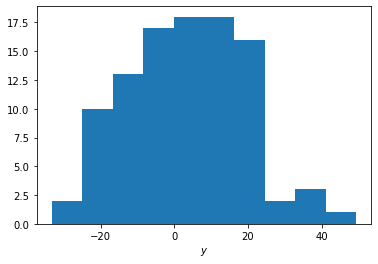

In [5]:
plt.hist(trace['obs'][-1])
plt.xlabel('$y$');

In [7]:
import scipy as sp

In [8]:
alpha = 10.
H = sp.stats.norm

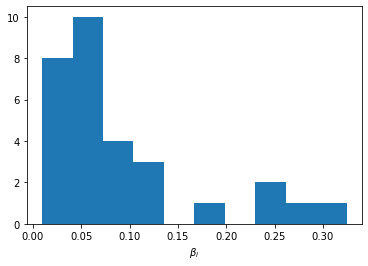

In [9]:
K = 30

beta = sp.stats.beta.rvs(1, alpha, size=K)
plt.hist(beta);
plt.xlabel(r'$\beta_i$');

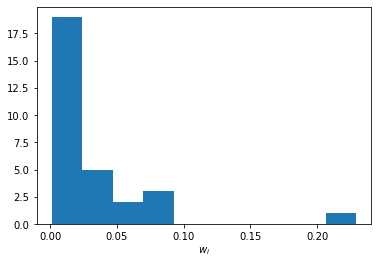

In [10]:
w = np.empty_like(beta)

w[0] = beta[0]
w[1:] = beta[1:] * (1 - beta[:-1]).cumprod()

plt.hist(w)
plt.xlabel(r'$w_i$');

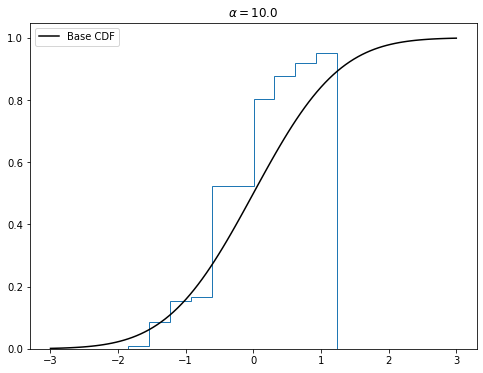

In [11]:
theta = H.rvs(size=K)

xs = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(theta, cumulative=True, weights=w, histtype='step')
ax.plot(xs, H.cdf(xs), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2);

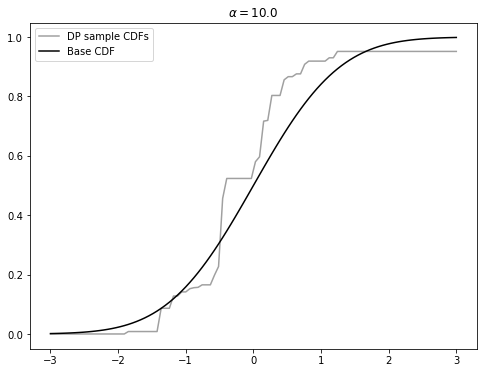

In [12]:
sample_cdf = (w[..., np.newaxis] * np.less.outer(theta, xs)).sum(axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(xs, sample_cdf, c='gray', alpha=0.75, label='DP sample CDFs')
ax.plot(xs, H.cdf(xs), c='k', label='Base CDF')

ax.set_title(r'$\alpha = {}$'.format(alpha))
ax.legend(loc=2);

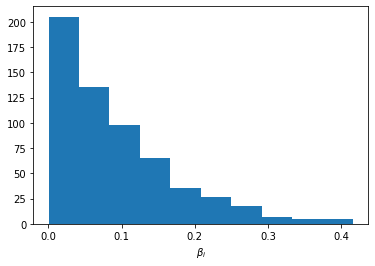

In [13]:
N = 20

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
plt.hist(beta.flatten())
plt.xlabel(r'$\beta_i$');

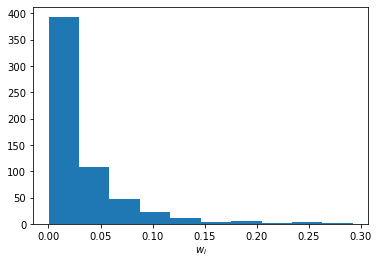

In [14]:
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
plt.hist(w.flatten())
plt.xlabel(r'$w_i$');

In [15]:
theta = H.rvs(size=(N, K))
sample_cdfs = (w[..., np.newaxis] * np.less.outer(theta, xs)).sum(axis=1)

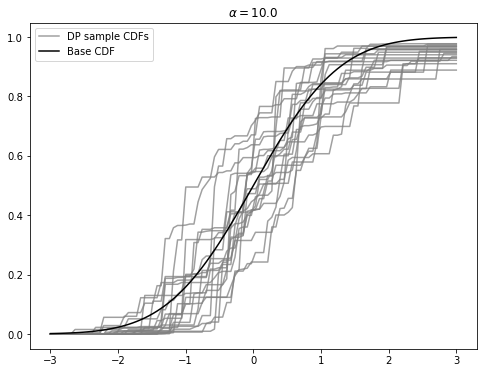

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(xs, sample_cdfs[0], c='gray', alpha=0.75, label='DP sample CDFs')
ax.plot(xs, sample_cdfs[1:].T, c='gray', alpha=0.75)
ax.plot(xs, H.cdf(xs), c='k', label='Base CDF')

ax.set_title(r'$\alpha = {}$'.format(alpha))
ax.legend(loc=2);


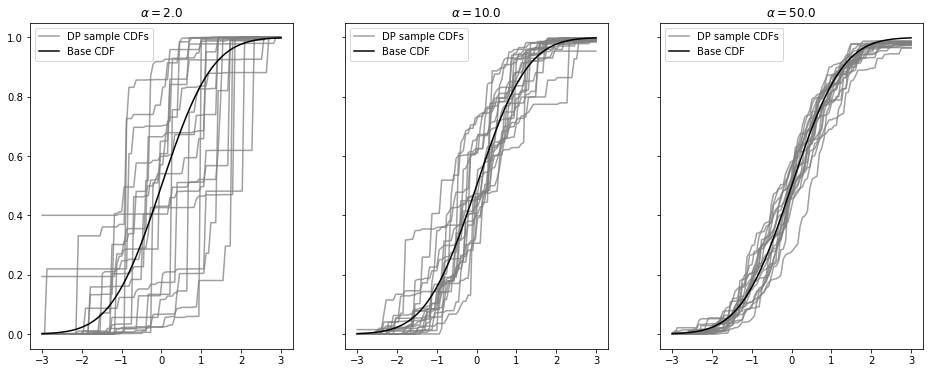

In [17]:
alphas = [2., 10., 50.]
Ks = [30, 50, 200]

fig, axs = plt.subplots(ncols=len(alphas), sharex=True, sharey=True, figsize=(16, 6))

for alpha, K, ax in zip(alphas, Ks, axs):
    beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
    w = np.empty_like(beta)
    w[:, 0] = beta[:, 0]
    w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
    
    theta = H.rvs(size=(N, K))
    
    sample_cdfs = (w[..., np.newaxis] * np.less.outer(theta, xs)).sum(axis=1)

    ax.plot(xs, sample_cdfs[0], c='gray', alpha=0.75, label='DP sample CDFs')
    ax.plot(xs, sample_cdfs[1:].T, c='gray', alpha=0.75)
    ax.plot(xs, H.cdf(xs), c='k', label='Base CDF')

    ax.set_title(r'$\alpha = {}$'.format(alpha))
    ax.legend(loc=2);

In [21]:
N = 5
K = 30

alpha = 2.
H = sp.stats.norm
def f(x, theta):
    σ = 0.3
    return sp.stats.norm.pdf(x, theta, σ)

In [22]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = H.rvs(size=(N, K))

dpm_pdf_components = f(xs[np.newaxis, np.newaxis, :], theta[..., np.newaxis])

In [23]:
theta[..., np.newaxis].shape

(5, 30, 1)

In [24]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = H.rvs(size=(N, K))

dpm_pdf_components = f(xs[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

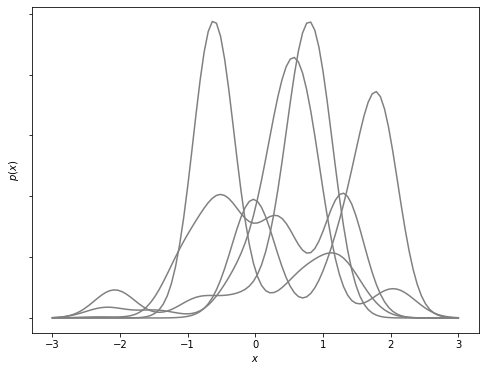

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xs, dpm_pdfs.T, c='gray')
ax.set_yticklabels([])
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$');